In [86]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import math
from scipy.stats import multivariate_normal
import seaborn as sns
from scipy.interpolate import Rbf
from src.plot_utils import *
from src.Influence_function import *
from matplotlib import animation

#### Merging EPTS data and event data

- Match 1

In [127]:
df = pd.read_json('./Data/sample_match_1_with_v.json')
e_df = pd.read_json('./Data/sample_Game_1_events.json')

In [128]:
set(e_df.Type)

{'BALL LOST',
 'BALL OUT',
 'CARD',
 'CHALLENGE',
 'FAULT RECEIVED',
 'PASS',
 'RECOVERY',
 'SET PIECE',
 'SHOT'}

#### own the ball situation

- Time between "BALL LOST" to "BALL LOST"
- After 5 seconds from intercept (recovery time)

In [129]:
t_df = e_df[['Team', 'Type', 'Start Frame', 'End Frame', 'Period']]
t_df = pd.concat([t_df, t_df.shift(-1).rename(columns={'Team': 'Next Team', 
                                                       'Type' : 'Next Type',
                                                       'Start Frame' : 'Next Start Frame',
                                                       'End Frame' : 'Next End Frame',
                                                       'Period' : 'Next Period'})], axis=1)
t_df = t_df[(t_df['Start Frame'] < t_df['Next End Frame']) &
      (t_df['Team'] == t_df['Next Team']) & 
      (t_df['Period'] == t_df['Next Period']) &
      ((t_df['Type'] == 'PASS') | (t_df['Type'] == 'RECOVERY'))]
t_df.reset_index(drop=True, inplace=True)
t_df.head(20)

,Team,Type,Start Frame,End Frame,Period,Next Team,Next Type,Next Start Frame,Next End Frame,Next Period
0,Away,PASS,1,3,1,Away,PASS,3.0,17.0,1.0
1,Away,PASS,3,17,1,Away,PASS,45.0,61.0,1.0
2,Away,PASS,45,61,1,Away,PASS,77.0,96.0,1.0
3,Away,PASS,77,96,1,Away,PASS,191.0,217.0,1.0
4,Away,PASS,191,217,1,Away,PASS,279.0,303.0,1.0
5,Away,PASS,279,303,1,Away,BALL LOST,346.0,380.0,1.0
6,Home,RECOVERY,378,378,1,Home,BALL LOST,378.0,452.0,1.0
7,Away,RECOVERY,453,453,1,Away,BALL LOST,453.0,497.0,1.0
8,Home,RECOVERY,498,498,1,Home,PASS,498.0,536.0,1.0
9,Home,PASS,498,536,1,Home,PASS,536.0,556.0,1.0


In [130]:
n_list = np.zeros(len(df))
for i in range(len(t_df)):
    s_frame, f_frame = np.array(t_df.loc[i, ['Start Frame', 'Next End Frame']])
    if math.isnan(s_frame*f_frame) == False:
        if t_df.loc[i, 'Team'] == 'Home':
            n_list[int(s_frame) :int(f_frame)] = 1
        if t_df.loc[i, 'Team'] == 'Away':
            n_list[int(s_frame):int(f_frame)] = 2
for i in range(len(t_df)):
    if t_df.loc[i,'Type'] == 'RECOVERY':
        s_frame, f_frame = t_df.loc[i, ['Start Frame','End Frame']]
        n_list[int(s_frame - 25):int(f_frame + 25*5)] = 0


In [131]:
df['owning'] = n_list

In [132]:
df[df['owning'] != 0]

,Period,Frame,Time [s],H11_x,H11_y,H1_x,H1_y,H2_x,H2_y,H3_x,...,A12_x_v,A12_y_v,A12_v_abs,A13_x_v,A13_y_v,A13_v_abs,A14_x_v,A14_y_v,A14_v_abs,owning
3,1,2,0.08,0.09984,32.80184,33.95392,44.41896,35.04904,33.22684,32.16408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,1,3,0.12,0.11856,32.80184,33.95392,44.41896,35.04904,33.22684,32.16408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
5,1,4,0.16,0.12584,32.80184,33.92688,44.41556,35.03448,33.31184,32.18176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
6,1,5,0.20,0.13416,32.80184,33.90088,44.38292,35.01056,33.33224,32.18592,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
7,1,6,0.24,0.14560,32.80184,33.88424,44.30812,34.98248,33.29688,32.21712,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143589,2,143588,5743.52,91.81952,32.91472,NaN,NaN,50.39320,30.05804,54.46688,...,-5.80320,0.46580,5.821864,-4.66752,1.62112,4.941030,-2.74560,0.16388,2.750487,1.0
143590,2,143589,5743.56,91.78936,32.92220,NaN,NaN,50.33392,30.07912,54.39824,...,-5.76056,0.47940,5.780474,-4.64568,1.61500,4.918391,-2.69048,0.19380,2.697451,1.0
143591,2,143590,5743.60,91.76024,32.92968,NaN,NaN,50.27568,30.09476,54.33064,...,-5.71792,0.49232,5.739076,-4.62280,1.60004,4.891872,-2.63536,0.22304,2.644781,1.0
143592,2,143591,5743.64,91.73216,32.93648,NaN,NaN,50.21744,30.11108,54.26512,...,-5.67320,0.50524,5.695653,-4.59992,1.58508,4.865362,-2.57088,0.23120,2.581255,1.0


In [93]:
pc_m = pc_model()

In [94]:
np.random.seed(1)

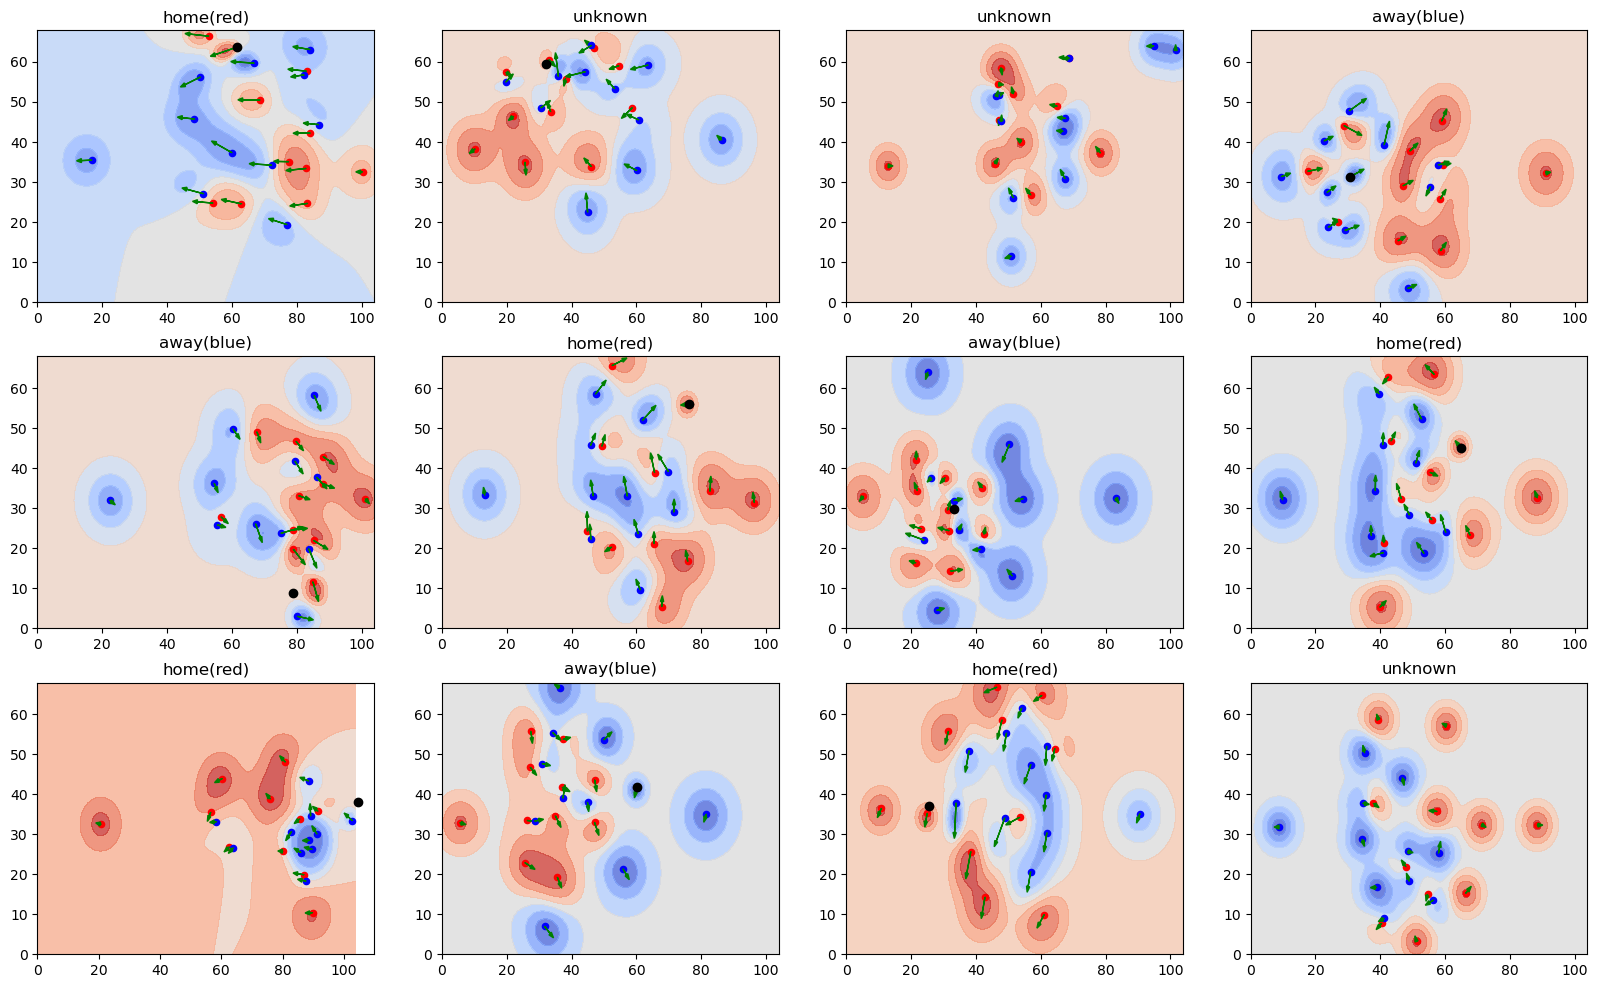

In [95]:
t_frames = np.random.randint(1, 140000, 12)
fig, axs = plt.subplots(3, 4, figsize=(20, 12))
plt.set_cmap('coolwarm')
for i, frame in enumerate(t_frames):
    x = i//4
    y = i%4
    _, _, _  = pc_m.plot_frame(frame, figx=(fig, axs[x, y]))
    owner = df[df['Frame']==frame]['owning'].values[0]
    if owner == 0:
        axs[x, y].set_title('unknown')
    elif owner == 1:
        axs[x, y].set_title('home(red)')
    elif owner == 2:
        axs[x, y].set_title('away(blue)')

#### Constructing the dataset

- p_kl : time(t), pitch location, bal's location
- p_b  : time(t), ball's location
- d_kl : time(t), ball's location, sum of defensive team's influence function value at certain location

#### Target Value $V_{k,l}(t)$

In [133]:
frame = 130000

In [134]:
t_df = df[df['Frame'] == frame]
period = t_df['Period'].values[0]
t_df = t_df.drop(['Period', 'Ball_x', 'Ball_y', 'Ball_v_abs'], axis=1).iloc[0,:]
positions = t_df[[i for i in t_df.index if (('_x' in i) or ('_y' in i)) and 'v' not in i]]
positions.dropna(inplace=True)
velocities = t_df[[i for i in t_df.index if '_v' in i]]
velocities.dropna(inplace=True)
points = np.array([[positions[2*i], positions[2*i+1]] for i in range(len(positions)//2)])
velocities = np.array([[velocities[3*i], velocities[3*i+1]] for i in range(len(velocities)//3)])
players = np.array([positions.index[2*i].split('_')[0] for i in range(len(points))])
ball_x, ball_y = df.loc[df['Frame'] == frame, ['Ball_x', 'Ball_y']].values[0]

In [135]:
t_df['owning']

2.0

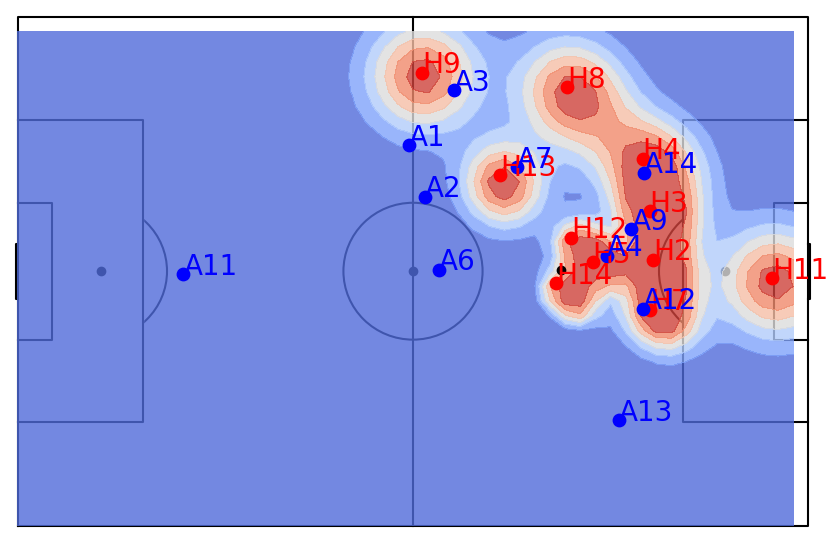

In [136]:
d_kl = 0

x, y = np.mgrid[0:104:2, 0:68:2]
locations = np.concatenate([x.reshape(-1,1), y.reshape(-1,1)], axis=1)

for i, j, k in zip(players, points, velocities):
    if t_df['owning'] == 2 :
        if period == 1:        # first half
            direction_flag = 0 # attack direction right to left
        else :                 # second half
            direction_flag = 1 # attack direction left to right
        if 'H' in i:
            d_kl += influence_function2(j, locations, k, (ball_x, ball_y))
    elif t_df['owning'] == 1:
        if period == 1 :
            direction_flag = 1
        else :
            direction_flag = 0
        if 'A' in i:
            d_kl += influence_function2(j, locations, k, (ball_x, ball_y))

d_kl[d_kl>=1] = 1
v_kl = d_kl

fig, ax = draw_pitch('white', 'black')
plt.set_cmap('coolwarm')
ax.contourf(x, y, v_kl.reshape(52, 34), alpha=0.8)
ax.scatter(ball_x, ball_y, c='black')
for t, p in zip(players, points):
    if 'H' in t:
        color = 'red'
    else:
        color = 'blue'
    
    ax.scatter(p[0], p[1], c=color, s=80)
    ax.text(p[0], p[1], s=t, fontsize=20, color=color)
        

##### Remove GK player location
 - game1) H11, A11
 - game2) H11, A25

In [113]:
df = df[[i for i in df.columns if not i.startswith('H11') and not i.startswith('A11')]]

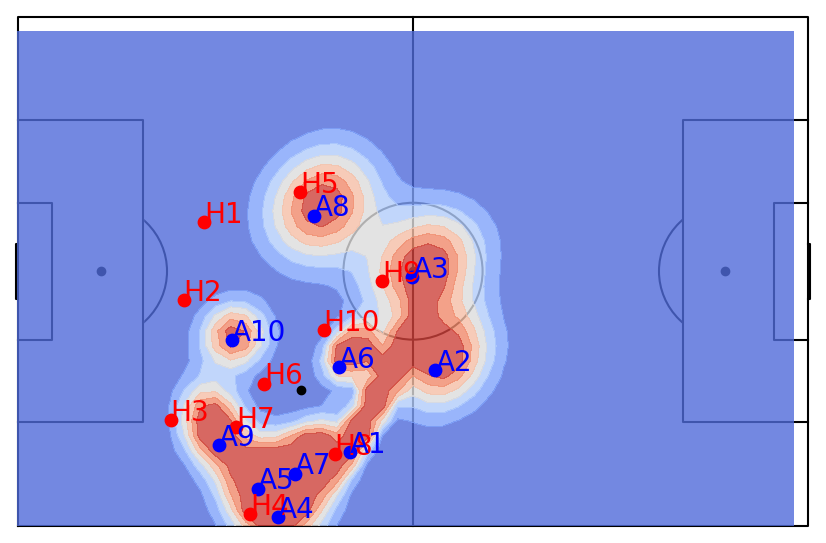

In [117]:
d_kl = 0

t_df = df[df['Frame'] == frame]
period = t_df['Period'].values[0]
t_df = t_df.drop(['Period', 'Ball_x', 'Ball_y', 'Ball_v_abs'], axis=1).iloc[0,:]
positions = t_df[[i for i in t_df.index if (('_x' in i) or ('_y' in i)) and 'v' not in i]]
positions.dropna(inplace=True)
velocities = t_df[[i for i in t_df.index if '_v' in i]]
velocities.dropna(inplace=True)
points = np.array([[positions[2*i], positions[2*i+1]] for i in range(len(positions)//2)])
velocities = np.array([[velocities[3*i], velocities[3*i+1]] for i in range(len(velocities)//3)])
players = np.array([positions.index[2*i].split('_')[0] for i in range(len(points))])
ball_x, ball_y = df.loc[df['Frame'] == frame, ['Ball_x', 'Ball_y']].values[0]

x, y = np.mgrid[0:104:2, 0:68:2]
locations = np.concatenate([x.reshape(-1,1), y.reshape(-1,1)], axis=1)

for i, j, k in zip(players, points, velocities):
    if t_df['owning'] == 2 :
        if period == 1:        # first half
            direction_flag = 0 # attack direction right to left
        else :                 # second half
            direction_flag = 1 # attack direction left to right
        if 'H' in i:
            d_kl += influence_function2(j, locations, k, (ball_x, ball_y))
    elif t_df['owning'] == 1:
        if period == 1 :
            direction_flag = 1
        else :
            direction_flag = 0
        if 'A' in i:
            d_kl += influence_function2(j, locations, k, (ball_x, ball_y))

d_kl[d_kl>=1] = 1
v_kl = d_kl

fig, ax = draw_pitch('white', 'black')
plt.set_cmap('coolwarm')
ax.contourf(x, y, v_kl.reshape(52, 34), alpha=0.8)
ax.scatter(ball_x, ball_y, c='black')
for t, p in zip(players, points):
    if 'H' in t:
        color = 'red'
    else:
        color = 'blue'
    
    ax.scatter(p[0], p[1], c=color, s=80)
    ax.text(p[0], p[1], s=t, fontsize=20, color=color)
        

(array([1369.,   73.,   46.,   45.,   34.,   28.,   33.,   17.,   23.,
         100.]),
 array([7.05859222e-37, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

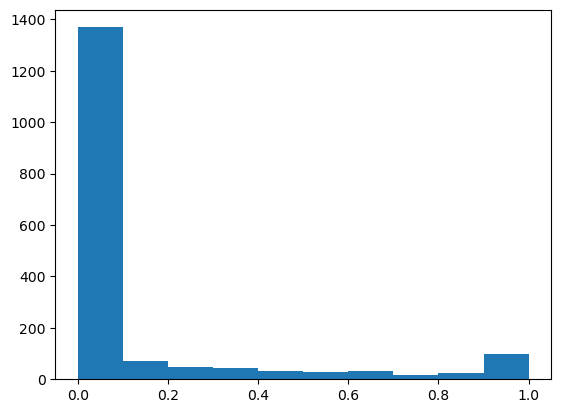

In [118]:
plt.hist(d_kl)

#### Function for constructing dataset

In [34]:
def frame_df(frame=frame):
    t_df = df[df['Frame'] == frame]
    period = t_df['Period'].values[0]
    t_df = t_df.drop(['Period', 'Ball_x', 'Ball_y', 'Ball_v_abs'], axis=1).iloc[0,:]
    positions = t_df[[i for i in t_df.index if (('_x' in i) or ('_y' in i)) and 'v' not in i]]
    positions.dropna(inplace=True)
    velocities = t_df[[i for i in t_df.index if '_v' in i]]
    velocities.dropna(inplace=True)
    points = np.array([[positions[2*i], positions[2*i+1]] for i in range(len(positions)//2)])
    velocities = np.array([[velocities[3*i], velocities[3*i+1]] for i in range(len(velocities)//3)])
    players = np.array([positions.index[2*i].split('_')[0] for i in range(len(points))])
    ball_x, ball_y = df.loc[df['Frame'] == frame, ['Ball_x', 'Ball_y']].values[0]

    x, y = np.mgrid[0:104:5, 0:68:5]
    locations = np.concatenate([x.reshape(-1,1), y.reshape(-1,1)], axis=1)

    if (len(velocities) != 20) or (len(points) != 20) :
        print('\r ' + ' '*100, end="")  
        print('\r no_player_data', end="") 
        return 0
    if math.isnan(ball_x) :
        print('\r ' + ' '*100, end="")  
        print('\r no_ball_data', end="")  
        return 0

    d_kl = 0
    
    for i, j, k in zip(players, points, velocities):
        if t_df['owning'] == 2 :
            if period == 1:        # first half
                direction_flag = 0 # attack direction right to left
            else :                 # second half
                direction_flag = 1 # attack direction left to right
            if 'H' in i:
                d_kl += influence_function2(j, locations, k, (ball_x, ball_y))
        elif t_df['owning'] == 1:
            if period == 1 :
                direction_flag = 1
            else :
                direction_flag = 0
            if 'A' in i:
                d_kl += influence_function2(j, locations, k, (ball_x, ball_y))
        else :
            print('\r ' + ' '*100, end="")  
            print('\r unknown owning', end="")
            return 0

    d_kl[d_kl>=1] = 1
    v_kl = d_kl

    if direction_flag == 1:
        tt_dict = {'v_kl':v_kl, 'Ball_x':np.ones(len(d_kl))*ball_x, 
                   'Ball_y':np.ones(len(d_kl))*ball_y, 'loc_x':locations[:,0], 'loc_y':locations[:,1],
                   'frame' :np.ones(len(d_kl))*frame}
    else :
        tt_dict = {'v_kl':v_kl, 'Ball_x':np.ones(len(d_kl))*(104 - ball_x),
                   'Ball_y':np.ones(len(d_kl))*ball_y, 'loc_x':104- locations[:,0], 'loc_y':locations[:,1],
                   'frame' :np.ones(len(d_kl))*frame}
    
    return pd.DataFrame(tt_dict)

In [35]:
tt_df = frame_df(94000)

In [37]:
pc_m2 = pc_model(2)

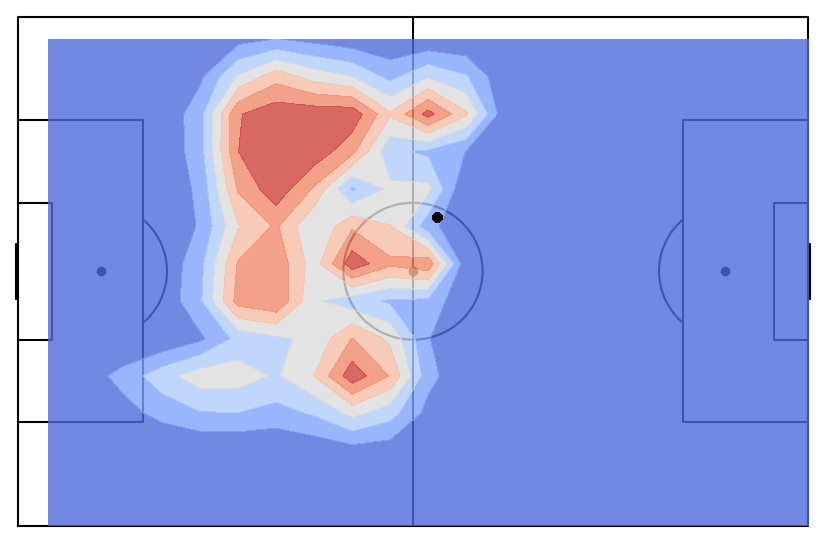

In [36]:
v_kl = tt_df['v_kl'].values
x = tt_df['loc_x'].values
y = tt_df['loc_y'].values
ball_x = tt_df['Ball_x'].values
ball_y = tt_df['Ball_y'].values
fig, ax = draw_pitch('white', 'black')
ax.contourf(x.reshape(21, 14), y.reshape(21, 14), v_kl.reshape(21, 14), alpha=0.8)
ax.scatter(ball_x, ball_y, color='black')

#### Making csv dataset

In [137]:
with open('./Data/dataset.csv', 'w') as csvfile:
    fieldnames = ['Ball_x', 'Ball_y', 'loc_x', 'loc_y', 'v_kl', 'frame']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

#### For sample game 1

In [138]:
df = pd.read_json('./Data/sample_match_1_with_v.json')
e_df = pd.read_json('./Data/sample_Game_1_events.json')

t_df = e_df[['Team', 'Type', 'Start Frame', 'End Frame', 'Period']]
t_df = pd.concat([t_df, t_df.shift(-1).rename(columns={'Team': 'Next Team', 
                                                       'Type' : 'Next Type',
                                                       'Start Frame' : 'Next Start Frame',
                                                       'End Frame' : 'Next End Frame',
                                                       'Period' : 'Next Period'})], axis=1)
t_df = t_df[(t_df['Start Frame'] < t_df['Next End Frame']) &
      (t_df['Team'] == t_df['Next Team']) & 
      (t_df['Period'] == t_df['Next Period']) &
      ((t_df['Type'] == 'PASS') | (t_df['Type'] == 'RECOVERY'))]
t_df.reset_index(drop=True, inplace=True)

n_list = np.zeros(len(df))
for i in range(len(t_df)):
    s_frame, f_frame = np.array(t_df.loc[i, ['Start Frame', 'Next End Frame']])
    if math.isnan(s_frame*f_frame) == False:
        if t_df.loc[i, 'Team'] == 'Home':
            n_list[int(s_frame) :int(f_frame)] = 1
        if t_df.loc[i, 'Team'] == 'Away':
            n_list[int(s_frame):int(f_frame)] = 2
for i in range(len(t_df)):
    if t_df.loc[i,'Type'] == 'RECOVERY':
        s_frame = t_df.loc[i, 'Start Frame']
        n_list[int(s_frame-25):int(s_frame + 25*5)] = 0

df = df[[i for i in df.columns if not i.startswith('H11') and not i.startswith('A11')]]
df['owning'] = n_list
fieldnames = ['Ball_x', 'Ball_y', 'loc_x', 'loc_y', 'v_kl', 'frame']

#for frame in np.arange(1, len(df['Frame']), 75):
for frame in np.arange(1, len(df['Frame']), 75):
    tt_df = frame_df(frame=frame)
    if type(tt_df) != pd.DataFrame:
        continue

    with open('./Data/dataset.csv', 'a') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        for idx in range(len(tt_df)):
            writer.writerow(tt_df.iloc[idx].to_dict())

    print('\r ' + ' '*100, end="")            
    print('\r' + str(frame)+'/'+str(len(df)) +' frame ', end="")
    

 no_ball_data                                                                                        

#### For sample game 2

In [139]:
df = pd.read_json('./Data/sample_match_2_with_v.json')
e_df = pd.read_json('./Data/sample_Game_2_events.json')

t_df = e_df[['Team', 'Type', 'Start Frame', 'End Frame', 'Period']]
t_df = pd.concat([t_df, t_df.shift(-1).rename(columns={'Team': 'Next Team', 
                                                       'Type' : 'Next Type',
                                                       'Start Frame' : 'Next Start Frame',
                                                       'End Frame' : 'Next End Frame',
                                                       'Period' : 'Next Period'})], axis=1)
t_df = t_df[(t_df['Start Frame'] < t_df['Next End Frame']) &
      (t_df['Team'] == t_df['Next Team']) & 
      (t_df['Period'] == t_df['Next Period']) &
      ((t_df['Type'] == 'PASS') | (t_df['Type'] == 'RECOVERY'))]
t_df.reset_index(drop=True, inplace=True)

n_list = np.zeros(len(df))
for i in range(len(t_df)):
    s_frame, f_frame = np.array(t_df.loc[i, ['Start Frame', 'Next End Frame']])
    if math.isnan(s_frame*f_frame) == False:
        if t_df.loc[i, 'Team'] == 'Home':
            n_list[int(s_frame) :int(f_frame)] = 1
        if t_df.loc[i, 'Team'] == 'Away':
            n_list[int(s_frame):int(f_frame)] = 2
for i in range(len(t_df)):
    if t_df.loc[i,'Type'] == 'RECOVERY':
        s_frame = t_df.loc[i, 'Start Frame']
        n_list[int(s_frame-25):int(s_frame + 25*5)] = 0

df = df[[i for i in df.columns if not i.startswith('H11') and not i.startswith('A25')]]
df['owning'] = n_list
fieldnames = ['Ball_x', 'Ball_y', 'loc_x', 'loc_y', 'v_kl', 'frame']

#for frame in np.arange(1, len(df['Frame']), 75):
for frame in np.arange(1, len(df['Frame']), 75):
    tt_df = frame_df(frame=frame)
    if type(tt_df) != pd.DataFrame:
        continue

    ################# Notice the attack direction in game1 is opposite to game2
    tt_df['Ball_x'] = 104 - tt_df['Ball_x']
    tt_df['loc_x'] = 104 - tt_df['loc_x']

    with open('./Data/dataset.csv', 'a') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        for idx in range(len(tt_df)):
            writer.writerow(tt_df.iloc[idx].to_dict())

    print('\r ' + ' '*100, end="")             
    print('\r' + str(frame)+'/'+str(len(df)) +' frame ', end="")

 no_ball_data                                                                                        

#### Checking the data values

In [140]:
df = pd.read_csv('./Data/dataset.csv')

In [141]:
df.shape

(426006, 6)

In [142]:
df.head()

,Ball_x,Ball_y,loc_x,loc_y,v_kl,frame
0,56.93168,21.4574,104.0,0.0,6.434415e-15,76.0
1,56.93168,21.4574,104.0,5.0,6.679397e-14,76.0
2,56.93168,21.4574,104.0,10.0,1.945478e-13,76.0
3,56.93168,21.4574,104.0,15.0,1.632318e-13,76.0
4,56.93168,21.4574,104.0,20.0,2.903645e-13,76.0


In [143]:
ball_list = df.groupby(by=['Ball_x', 'Ball_y']).mean().index.to_list()
ball_list = [(i[0], i[1]) for i in ball_list if 80 < i[0] and i[0] < 90 and i[1] > 25 and i[1] < 35]

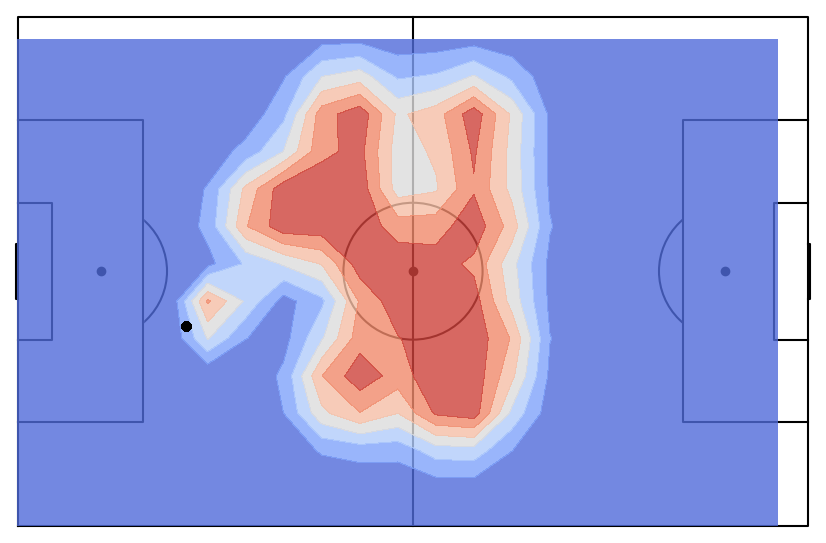

In [144]:
t_idx = 3
tt_df = df[(df['Ball_x']==ball_list[t_idx][0]) & (df['Ball_y']==ball_list[t_idx][1])]
tt_df = df[df['frame']==30601]
v_kl = tt_df['v_kl'].values
x = tt_df['loc_x'].values
y = tt_df['loc_y'].values
ball_x = tt_df['Ball_x'].values
ball_y = tt_df['Ball_y'].values
fig, ax = draw_pitch('white', 'black')
ax.contourf(x.reshape(21, 14), y.reshape(21, 14), v_kl.reshape(21, 14), alpha=0.8)
ax.scatter(ball_x, ball_y, color='black')